In [1]:
!pip install fastai==2.7.9
!pip install fastkaggle==0.0.7
!pip install fasterai==0.1.11
!pip install ipython-autotime==0.3.1
!pip install torch==1.12.1
!pip install fairscale==0.4.6
%load_ext autotime

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: pynvml
    Found existing installation: pynvml 11.5.0
    Uninstalling pynvml-11.5.0:
      Successfully uninstalled pynvml-11.5.0
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.5/225.5 kB 5.6 MB/s eta 0:00:0000:01
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.11
    Uninstalling fastai-2.7.11:
      Successfully uninstalled fastai-2.7.11
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo

In [5]:
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.data.all import *
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
from fastai.fp16_utils import *

from fasterai.sparse.all import *
from fasterai.core.criteria import *
from fasterai.regularize.all import *

from fastkaggle import *

from fairscale.experimental.tooling.layer_memory_tracker import LayerwiseMemoryTracker

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle as pkl

from test_roc_prc import ROC, PRC
import gc

import inspect


set_seed(42)

time: 12.6 s (started: 2023-04-08 07:29:01 +00:00)


In [8]:
@patch
def custom_plot_losses(self: Recorder, skip_start=5, with_valid=True, filename="temp.txt"):
    fig2 = plt.figure("Figure 2")

    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_loss') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train loss')
    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_loss') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid loss')
        plt.legend()

    
@patch
def custom_plot_values(self: Recorder, skip_start=5, with_valid=True):
    fig3 = plt.figure("Figure 3")
    
    idx = (np.array(self.iters)<skip_start).sum()
    train_col = self.metric_names.index('train_accuracy') - 1 
    plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(train_col), label='train accuracy')

    plt.legend()
    if with_valid:
        idx = (np.array(self.iters)<skip_start).sum()
        valid_col = self.metric_names.index('valid_accuracy') - 1 
        plt.plot(self.iters[idx:], L(self.values[idx:]).itemgot(valid_col), label='valid accuracy')
        plt.legend()

time: 4.47 ms (started: 2023-04-08 07:29:14 +00:00)


In [9]:
comp = 'paddy-diseases/paddy-diseases'

path = setup_comp(comp, install='"fastcore>=1.4.5" "fastai>=2.7.1" "timm>=0.6.2.dev0"')

time: 4min 55s (started: 2023-04-08 07:29:14 +00:00)


In [10]:
dls = ImageDataLoaders.from_folder(path/"train", 
                                   valid_pct=0.25, 
                                   item_tfms=Resize(256), 
                                   batch_tfms=aug_transforms(   size=64, 
                                                                min_scale=0.75,
                                                                max_rotate=10., 
                                                                min_zoom=0.8, 
                                                                max_zoom=1.2, 
                                                            
                                                            ), 
                                   bs=32//8)

time: 14.7 s (started: 2023-04-08 07:34:09 +00:00)


In [11]:
sp_cb=[
      GradientAccumulation(32), 
#       SparsifyCallback(sparsity=18.75, 
#                          granularity='filter', 
#                          context='local', 
#                          criteria=large_final, 
#                          schedule=one_cycle),

]

time: 878 µs (started: 2023-04-08 07:34:24 +00:00)


In [12]:
model = vgg16_bn(num_classes=10)


time: 3.62 s (started: 2023-04-08 07:34:24 +00:00)


In [13]:
learn = Learner(dls, 
                model, 
                metrics=[accuracy,
                         error_rate,
                        ])
learn.unfreeze()
learn.recorder.train_metrics = True
learn.path = Path("/kaggle/working/")

time: 12.6 ms (started: 2023-04-08 07:34:28 +00:00)


epoch,train_loss,train_accuracy,train_error_rate,valid_loss,valid_accuracy,valid_error_rate,time
0,2.313021,0.168910,0.831090,2.087496,0.265385,0.734615,03:04
1,2.132396,0.208654,0.791346,2.043432,0.259135,0.740865,02:59
2,2.175248,0.221154,0.778846,2.024626,0.281250,0.718750,02:58
3,2.168156,0.234615,0.765385,2.004111,0.291827,0.708173,03:01
4,2.088136,0.243429,0.756571,1.943681,0.329808,0.670192,03:01
5,2.030635,0.258173,0.741827,1.916402,0.327404,0.672596,03:02
6,2.034047,0.275481,0.724519,1.862976,0.359615,0.640385,03:12
7,1.985094,0.278205,0.721795,1.821203,0.363942,0.636058,03:09
8,1.967292,0.295673,0.704327,1.843426,0.360096,0.639904,03:00
9,2.005892,0.316667,0.683333,1.736296,0.385096,0.614904,03:04


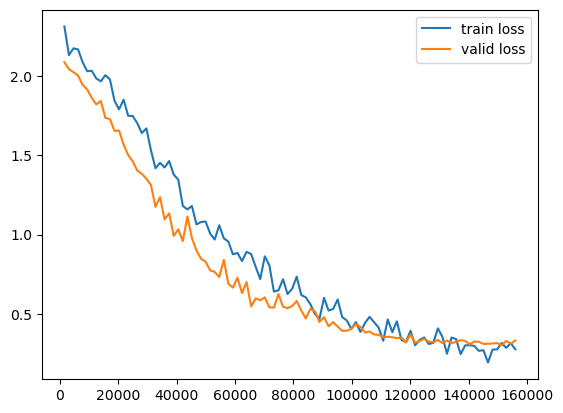

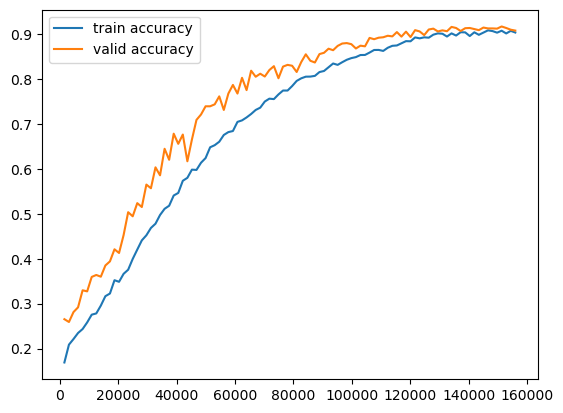

time: 3h 30min 46s (started: 2023-04-08 07:34:31 +00:00)


In [18]:
learn.fit_one_cycle(100, 3e-5, cbs=sp_cb)
                    
learn.recorder.custom_plot_losses()
learn.recorder.custom_plot_values()

In [23]:
learn.export(Path("/kaggle/working/VGG16_bn_accum8.pkl"))

time: 3.54 s (started: 2023-04-08 11:05:18 +00:00)


In [30]:
learner= load_learner(Path("/kaggle/working/VGG16_bn_accum8.pkl"))

time: 1.41 s (started: 2023-04-08 11:05:56 +00:00)


In [25]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files, with_labels=True,)


time: 542 ms (started: 2023-04-08 11:05:26 +00:00)


In [26]:
preds, _, idx = learner.get_preds(dl=tst_dl, with_decoded=True)
y_score = preds.numpy()

time: 27.7 s (started: 2023-04-08 11:05:27 +00:00)


In [27]:
y_onehot_test = (y_score == y_score.max(axis=1, keepdims=1)).astype(int)

time: 2.5 ms (started: 2023-04-08 11:05:55 +00:00)


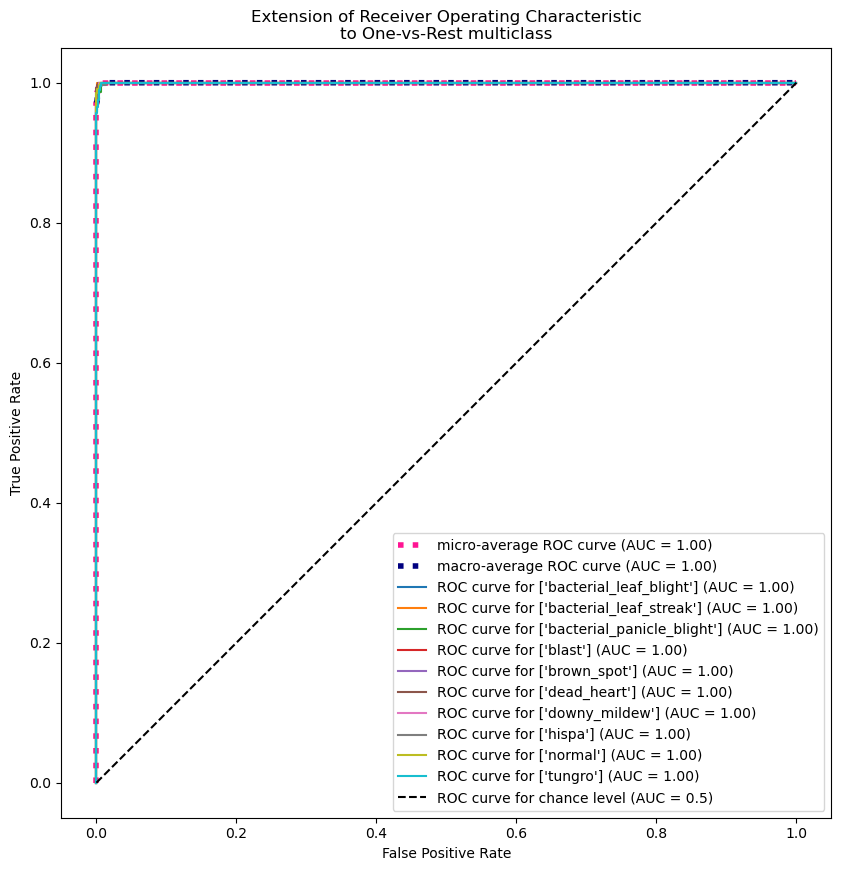

time: 502 ms (started: 2023-04-08 11:05:55 +00:00)


In [28]:
ROC(y_onehot_test, y_score, dls, 10)

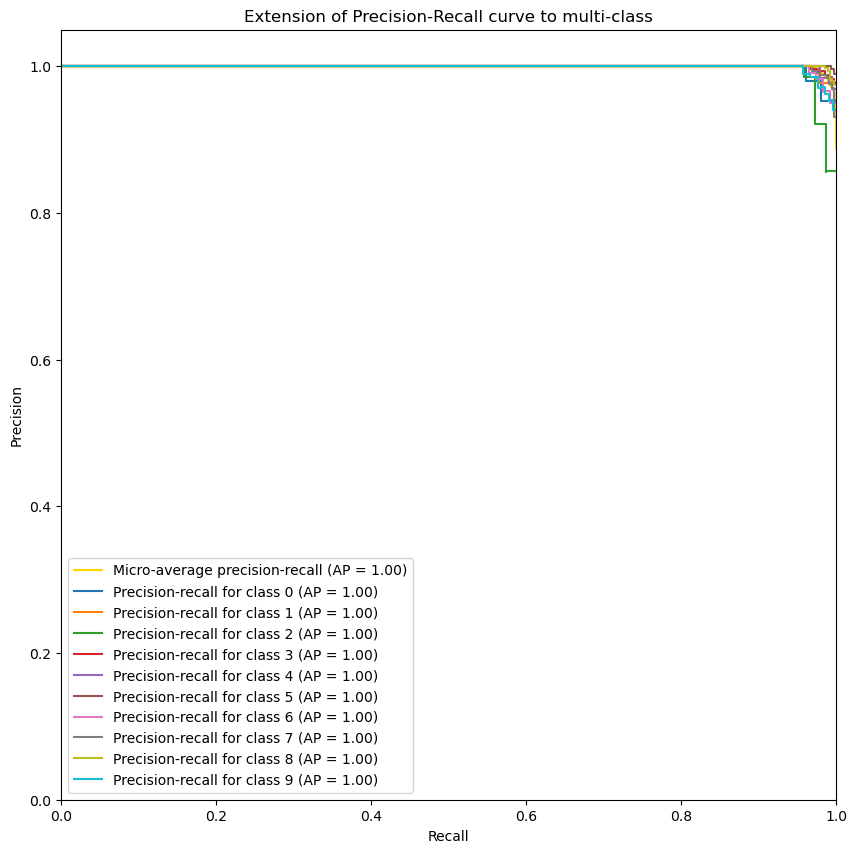

time: 437 ms (started: 2023-04-08 11:05:55 +00:00)


In [29]:
PRC(y_onehot_test, y_score, n_classes=10)

In [31]:
interpret = ClassificationInterpretation.from_learner(learner, dl=tst_dl)

time: 24 s (started: 2023-04-08 11:05:57 +00:00)


In [32]:
interpret.print_classification_report()

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.81      0.86      0.84        96
   bacterial_leaf_streak       0.80      0.95      0.87        76
bacterial_panicle_blight       0.86      0.91      0.89        68
                   blast       0.92      0.94      0.93       348
              brown_spot       0.88      0.87      0.87       193
              dead_heart       0.99      0.95      0.97       289
            downy_mildew       0.89      0.82      0.86       124
                   hispa       0.93      0.94      0.93       319
                  normal       0.94      0.94      0.94       353
                  tungro       0.89      0.84      0.87       218

                accuracy                           0.91      2084
               macro avg       0.89      0.90      0.90      2084
            weighted avg       0.91      0.91      0.91      2084

time: 23.9 s (started: 2023-04-08 11:06:21 +00:00)


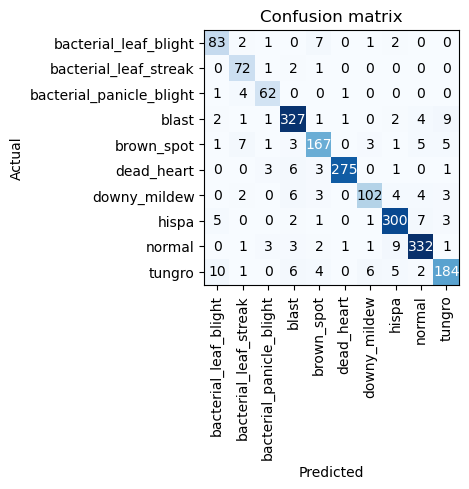

time: 24.5 s (started: 2023-04-08 11:06:45 +00:00)


In [33]:
interpret.plot_confusion_matrix()